## German Credit Analysis

## 1. Problem  

We aim to develop a credit scoring metric to classify people described by a set of attributes as good or bad "credit risk". Credit scoring allows banks to reduce financial losses, and for this reason, it plays a vital role in the financial industry.

Altogether, we have 20 explanatory variables (including 13 categorical variables) with one dependent variable called credit risk. The total number of observations is 1000. 

### Feature importance
For convenience, we split the data before the exploratory analysis in order to visualize the training dataset. Additionally, we will perform a feature selection analysis; we aim to measure the influence of each feature on the target variable to reduce the complexity of the final model; there is no point in paying for data that we don’t need. We will use three methods for feature selection, and for the purpose of comparison, I designed a baseline model. 

- **Baseline Model (or educated guess)**: includes all the features except the variables "Present residence since", "Number of existing credits" and "Number of people being liable to provide maintenance for the loan". I deleted these features manually based on their reduced ability to explain any difference in the target variable.
- **Standard deviation**: features were grouped by credit risk and we selected the features based upon a standard deviation above 0.10 with respect to the difference between good and bad credit risk. The idea is to try to capture the variance of the target variable through features' variance.
- **Spearman's rank-order correlation (absolute value)**: includes features based on a correlation above 0.05 with the target variable.  
- **Random forest classifier**: returns importance scores for each variable, all the importance scores add up to 100%.  Features with a score above 0.005 were selected.


Among these methods, Random Forest Classifier is one of the most straight forward models to apply for feature selection. Nonetheless, **I would like to clarify that all the methods presented for feature selection may be biased towards variables with many categories and large values, and also they are highly dependent on the chosen threshold**. The best way to go forward is to understand the mechanism of each method and use when required.

### Models
We will use robust and versatile classifier algorithms:

- Logistic regression
- Random Forest
- Gradient Boosting
- K-Nearest-Neighbors
- Decision Trees
- SVM

### Performance Measure

Note that we have changed the credit risk labels to 1 and 0:

$$
  \begin{equation}
       y = 
        \begin{cases}
            0 & \text{Good credit risk} \\
            1 & \text{Bad credit risk}
        \end{cases}
    \end{equation}
$$

One of the performance measures will be **Accuracy**, the fraction of correct predictions, along with other measures as **Precision, Recall and F1-Score**. 


$$
\textrm{Accuracy} = \frac{\textrm{TP+TN}}{\textrm{TP+TN+FP+FN} }
$$

Nonetheless, accuracy might not be the best metric to determine the quality of the model in this case so that **Recall will be pivotal because of misclassification is costly to the financial institution if the model predicts a low credit risk for someone who is actually a high credit risk (false negative)**. 


$$
\textrm{Recall} = \frac{\textrm{TP}}{\textrm{TP+FN} }
$$

**Additionally, we will present the average precision curve**, because this measure can expose differences between algorithms that are not apparent in the ROC-AUC measure.

**Decision rule to accept the best model**: the bank should approve the candidate only if the average profit increases or remains the same.

$$\text{Average profit}=\text{Average Credit Amount}*[(\text{Cost of False Negative)}*(\%FN)+(\text{Average Interest Rate})*(\%TN)]$$

Where the cost of a false negative is equal to 100% (total loss) and we can assume an average geometric retun of 20%. So the decision rule becomes:

$$\text{Average profit}=\text{Average Credit Amount}*[(-1.0)*(\%FN)+(0.20)*(\%TN)]$$


## 2. Getting the data

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import linear_model, preprocessing, model_selection 
from scipy.stats import spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import StandardScaler

NOTEBOOK_ROOT = "~\Desktop\MSFE\Sem_2\Machine_Learning\Project_Midterm\data"

columns= ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallment', 'housing', 'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'creditrisk']

credit_data = pd.read_csv( os.path.join(NOTEBOOK_ROOT, "credit_data.csv"), skiprows=1, names = columns )

In [2]:
credit_data.head()

,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallment,housing,existingcredits,job,peopleliable,telephone,foreignworker,creditrisk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [3]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
existingchecking    1000 non-null object
duration            1000 non-null int64
credithistory       1000 non-null object
purpose             1000 non-null object
creditamount        1000 non-null int64
savings             1000 non-null object
employmentsince     1000 non-null object
installmentrate     1000 non-null int64
statussex           1000 non-null object
otherdebtors        1000 non-null object
residencesince      1000 non-null int64
property            1000 non-null object
age                 1000 non-null int64
otherinstallment    1000 non-null object
housing             1000 non-null object
existingcredits     1000 non-null int64
job                 1000 non-null object
peopleliable        1000 non-null int64
telephone           1000 non-null object
foreignworker       1000 non-null object
creditrisk          1000 non-null int64
dtypes: int64(8), object(13)
memory usage

There aren't any missing values.

In [4]:
credit_data.isnull().values.any()

False

In [5]:
credit_data.describe()

,duration,creditamount,installmentrate,residencesince,age,existingcredits,peopleliable,creditrisk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


In [6]:
Attributes = tuple(open('credit_data_attributes.txt', 'r'))
Attributes

('Attribute 1:  (qualitative)\n',
 '\t       Status of existing checking account\n',
 '               A11 :      ... <    0 DM\n',
 '\t       A12 : 0 <= ... <  200 DM\n',
 '\t       A13 :      ... >= 200 DM /\n',
 '\t\t     salary assignments for at least 1 year\n',
 '               A14 : no checking account\n',
 '\n',
 'Attribute 2:  (numerical)\n',
 '\t      Duration in month\n',
 '\n',
 'Attribute 3:  (qualitative)\n',
 '\t      Credit history\n',
 '\t      A30 : no credits taken/\n',
 '\t\t    all credits paid back duly\n',
 '              A31 : all credits at this bank paid back duly\n',
 '\t      A32 : existing credits paid back duly till now\n',
 '              A33 : delay in paying off in the past\n',
 '\t      A34 : critical account/\n',
 '\t\t    other credits existing (not at this bank)\n',
 '\n',
 'Attribute 4:  (qualitative)\n',
 '\t      Purpose\n',
 '\t      A40 : car (new)\n',
 '\t      A41 : car (used)\n',
 '\t      A42 : furniture/equipment\n',
 '\t      A43 : radio/t

The data set contains 1000 observations for each one of the 21 variables, out of which 8 are numerical variables including the target variable and 13 are categorical variables. Description of each one of the predictors has been organized in the following table:

 ###  <span style="color:blue"> <div style="text-align: justify"> To use a classification model where the target variable is 1=Default and 0=Non-default, I replaced the values 1-2 for 0-1 in credit risk column. I did this because it will be useful for the next section.

In [7]:
credit_data['creditrisk'].replace([1,2], [0,1], inplace=True)

#### Splitting the data into training and testing set

In [8]:
X_train, X_test,y_train, y_test = train_test_split(credit_data.loc[:, 'existingchecking':'foreignworker' ], credit_data.loc[:,["creditrisk"]],test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)

(800, 20) (800, 1)


In [9]:
train=pd.merge(X_train, y_train, left_index=True, right_index=True)
train.head()

,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallment,housing,existingcredits,job,peopleliable,telephone,foreignworker,creditrisk
29,A11,60,A33,A49,6836,A61,A75,3,A93,A101,...,A124,63,A143,A152,2,A173,1,A192,A201,1
535,A13,21,A34,A46,2319,A61,A72,2,A91,A101,...,A123,33,A143,A151,1,A173,1,A191,A201,1
695,A14,6,A32,A41,1236,A63,A73,2,A93,A101,...,A122,50,A143,A151,1,A173,1,A191,A201,0
557,A14,21,A30,A40,5003,A65,A73,1,A92,A101,...,A122,29,A141,A152,2,A173,1,A192,A201,1
836,A14,12,A32,A43,886,A65,A73,4,A92,A101,...,A123,21,A143,A152,1,A173,1,A191,A201,0


Converting the target variable from dataframe to a numpy array.

In [10]:
y_train, y_test=y_train['creditrisk'].values, y_test['creditrisk'].values

## 3. Exploring the training dataset

Quick access for numerical and categorical variables

In [11]:
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallment', 'housing', 'job', 
           'telephone', 'foreignworker']


numvars = ['creditamount', 'duration', 'age','installmentrate', 'residencesince',  
           'existingcredits', 'peopleliable']

Total_Cols=numvars+catvars

The **class distribution of the dataset is imbalanced** since the number of high-risk customers is significantly less than that of low-risk customers. **Accuracy is not sensitive to imbalance at all, while Precision, Recall and F1 are.**

In [12]:
print('Credit risk in the training data')
train["creditrisk"].value_counts()

Credit risk in the training data


0    559
1    241
Name: creditrisk, dtype: int64

### Numerical features

One interesting property of this data set is that the columns ‘age’, 'credit amount' and 'duration' has some problems with the outliers. Thus I will handle this problem in the feature engineering section.

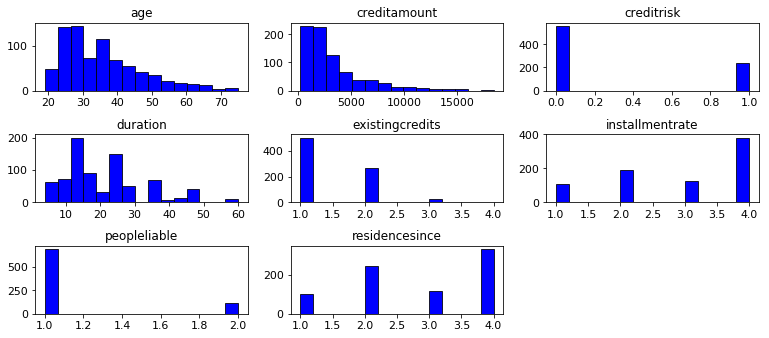

In [13]:
train.hist(bins=15, color='blue', edgecolor='black', linewidth=0.8, xlabelsize=11, ylabelsize=11, grid=False)    
plt.tight_layout(rect=(0, 0, 1.8, 1.2))  

In [14]:
train.groupby('creditrisk').mean()

,duration,creditamount,installmentrate,residencesince,age,existingcredits,peopleliable
creditrisk,,,,,,,
0,19.531306,3050.166369,2.932021,2.838998,36.599284,1.423971,1.144902
1,24.721992,4080.713693,3.041494,2.863071,33.145228,1.381743,1.141079


**Percentage of good and bad credit risk**

It is clear that the bank prefers to lend money to only one person able to provide maintenance for the loan, who have 1 existing credit and have lived in the same residence for 4 years. What is more interesting is that the percentage of good and bad credit is more or less similar between different values among those variables.

In [15]:
pd.crosstab(train['creditrisk'],train['installmentrate']).apply(lambda r: r/r.sum(), axis=1)

installmentrate,1,2,3,4
creditrisk,,,,
0,0.143113,0.243292,0.152057,0.461538
1,0.124481,0.215768,0.153527,0.506224


In [16]:
pd.crosstab(train['creditrisk'],train['existingcredits']).apply(lambda r: r/r.sum(), axis=1)

existingcredits,1,2,3,4
creditrisk,,,,
0,0.618962,0.343470,0.032200,0.005367
1,0.651452,0.323651,0.016598,0.008299


In [17]:
pd.crosstab(train['creditrisk'],train['residencesince']).apply(lambda r: r/r.sum(), axis=1)

residencesince,1,2,3,4
creditrisk,,,,
0,0.139535,0.296959,0.148479,0.415027
1,0.107884,0.336100,0.141079,0.414938


In [18]:
pd.crosstab(train['creditrisk'],train['peopleliable']).apply(lambda r: r/r.sum(), axis=1)

peopleliable,1,2
creditrisk,,
0,0.855098,0.144902
1,0.858921,0.141079


We can observe the following from the charts below:
- **Age**: the graph shows that young people tend to be riskier.
- **Duration**: customers with a higher loan duration appear to be on the risk side compare with those on the good side.
- **Credit amount**: the credit amount borrowed for costumers with bad risk is larger in general as compared to good ones. Amounts higher than 7,500 have a greater chance of default.
- **Instalment rate**: as installment rate increases the credit amount decreases for good and bad credit risk, but the prorportion of customers with credit risk relative to good risk increases.
- **Number of existing credits**: people who have other credits and have bad risk borrow a higher credit amount relative to customers without credit risk.
- **Number of people liable**: one customer having a bad credit risk borrows a higher amount of money instead of two customers being able to pay the loan.
- **Residence since**: it seems not to have a clear relationship with the target variable.

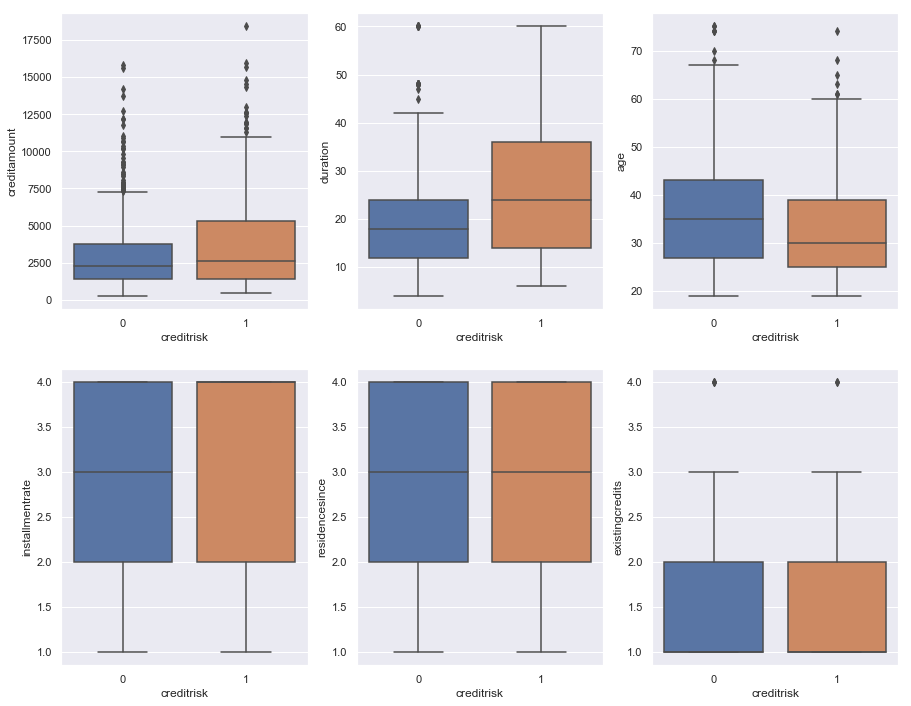

In [19]:
sns.set(font_scale=1)
num, axes = plt.subplots(2, 3,figsize=(15,12))
x,y=0,0
for column in numvars:
    sns.boxplot( x = 'creditrisk', y=column, data = train, orient = 'v', ax=axes[x,y])
    y+=1
    if y>2:
        x+=1
        y=0
    if x>1:
        break

**Credit risk given credit amount borrowed**

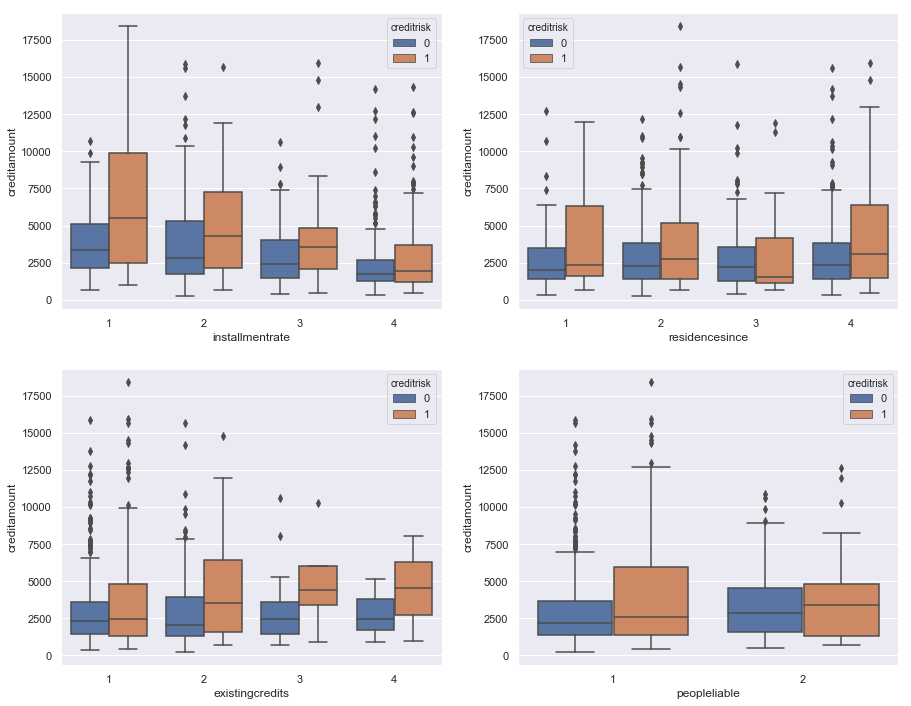

In [20]:
numvars_2 = ['installmentrate', 'residencesince', 'existingcredits', 'peopleliable']
sns.set(font_scale=1)
num, axes = plt.subplots(2, 2,figsize=(15,12))
x,y=0,0
for column in numvars_2:
    sns.boxplot( x = column, y = 'creditamount', hue = 'creditrisk', data = train, orient = 'v', ax=axes[x,y] )
    y+=1
    if y>1:
        x+=1
        y=0
    if x>1:
        break

**Correlation Matrix among numerical features**

The figure below shows that **"Duration", "Credit amount" and "Age" have the highest (absolute) correlation among other features with the target variable**. Furthermore, the variables "Present residence" and "Number of people being liable to provide maintenance for" seem to have no correlation with the target variable.

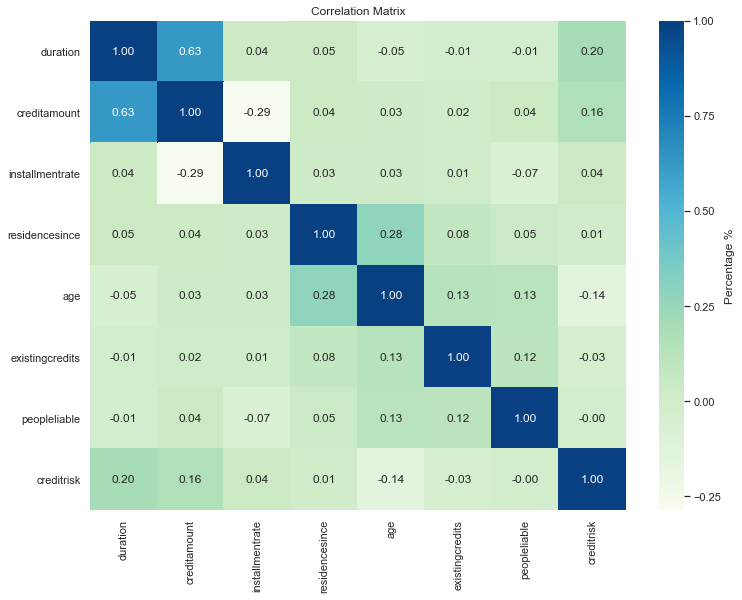

In [21]:
num,ax = plt.subplots(figsize=(12, 9))
sns.heatmap(train.corr(), annot=True, fmt=".2f",cbar_kws={'label': 'Percentage %'},cmap="GnBu",ax=ax)
ax.set_title("Correlation Matrix")
plt.show()

### Categorical features

In the case of categorical variables, the percentage of good ad bad credit differs between different values, which is helpful to explain the variation between good and bad risk.

- **Existing Checking Account**: customers without a checking account have the greatest percentage of good risk, whereas customers having checking account without any balance have a higher chance of default.
- **Credit History**: for categories such as "No credits taken" and surprisingly for "All credits at this bank paid back duly" the credit risk is greater relative to other categories. Note that the variable"existing credits paid back duly till know" could be a better predictor than the numerical variable "Number of existing credits".
- **Purpose**: loans used to buy a new car, furniture and television/radio comprise around seventy percent of the good/bad credit risk.
- **Savings**: people with savings lower than 100 DM tend to be riskier.
- **Employment since**: people employed less than 1 year and between 1 and 4 years have a higher credit risk relative to people with good credit risk
- **Sex/Status**: single males borrow more but divorced/separated males tend to be riskier. 
- **Housing**: people who rent a house have higher credit risk.
- **Foreign worker**: it seems that the bank's business is lending money to foreign people, and they tend to be a source of credit risk. 

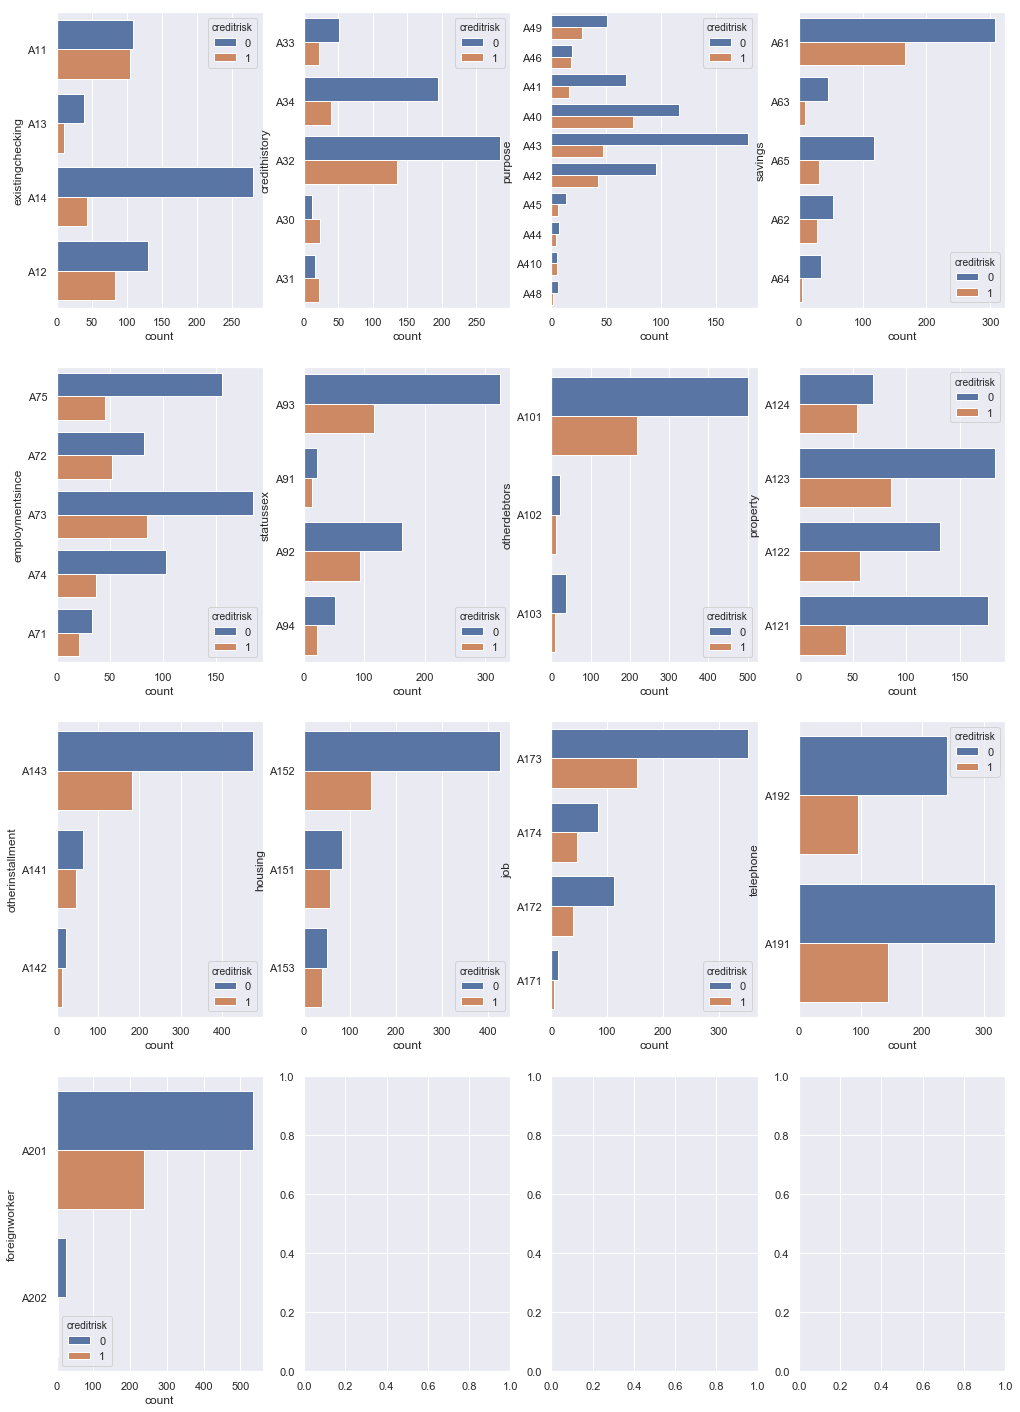

In [22]:
sns.set(font_scale=1)
cat, axes = plt.subplots(4, 4,figsize=(17,25))
x,y=0,0
for column in catvars:
    sns.countplot(y=column, hue="creditrisk", data=train, ax=axes[x,y])
    y+=1
    if y>3:
        x+=1
        y=0
    if x>3:
        break

Let's take a quick look at the relationship between categorical and numerical features. It is intuitive to think that having enough money in a checking and savings account could reduce the source of credit risk. Other variables that are helpful to explain credit risk are "Emplyment sice" and "Credit history". 

#### How does the status of an existing checking account affect the proportion of defaulters by credit amount?

People with funds between 0 and 200 DM in their checking account have a greater risk and they tend to borrow a higher amount. Instead, people with funds above 200 DM tend to borrow around 250 and 5000 DM. This seems to be an adverse selection problem.

(0, 20000)

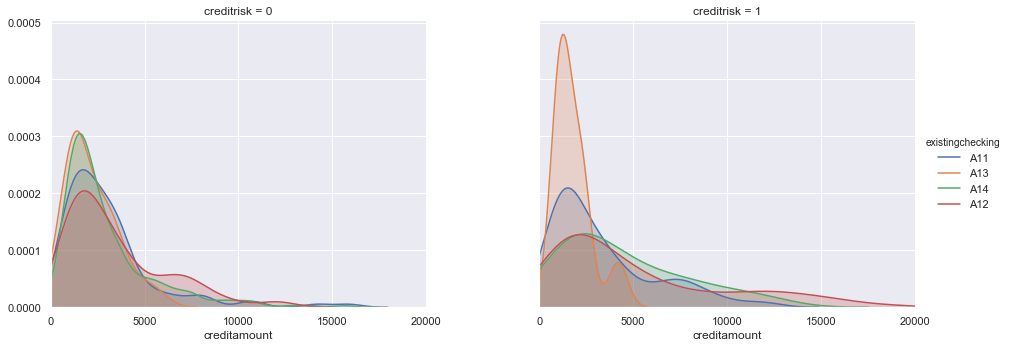

In [23]:
k = sns.FacetGrid(train, col="creditrisk", hue='existingchecking', height=5, aspect = 1.3)
k.map(sns.kdeplot, "creditamount", shade=True).add_legend().fig.subplots_adjust(wspace=.3)
sns.set(font_scale=2)
plt.xlim(0, 20000)

#### How does having a savings account affect the proportion of defaulters by duration of the loan?

People with funds lower than 100 DM and between 100 and 500 DM are riskier compared to other people and their duration tend to be the same as others.

(0, 100)

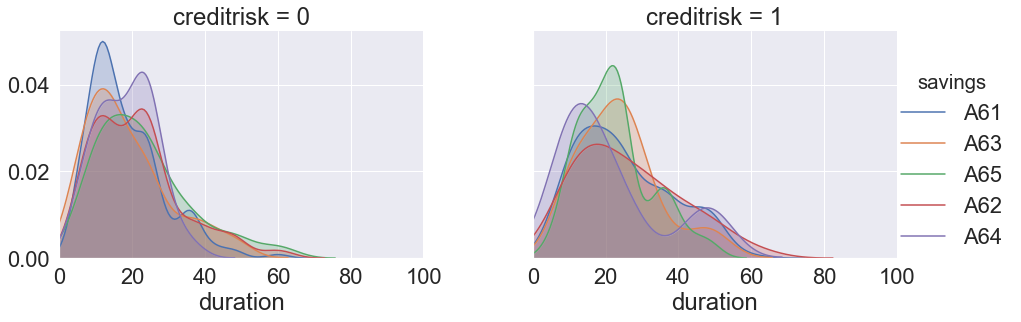

In [24]:
k = sns.FacetGrid(train, col="creditrisk", hue='savings', height=5, aspect = 1.3)
k.map(sns.kdeplot, "duration", shade=True).add_legend().fig.subplots_adjust(wspace=.3)
sns.set(font_scale=2)
plt.xlim(0, 100)

#### How does job stability affect the proportion of defaulters by age?

It might be premature to say young people tend to have bad credit records, but we can safely assume they tend to be riskier and they often have less experience.

(0, 100)

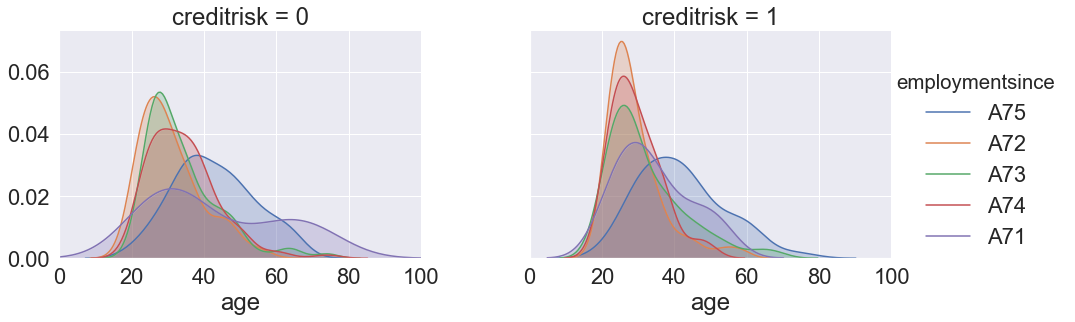

In [25]:
k = sns.FacetGrid(train, col="creditrisk", hue='employmentsince', height=5, aspect = 1.3)
k.map(sns.kdeplot, "age", shade=True).add_legend().fig.subplots_adjust(wspace=.3)
sns.set(font_scale=2)
plt.xlim(0, 100)

#### How does credit hisory affect the proportion of defaulters by age?

There is surprisingly a significant proportion of young people between 26 and 38 years who have not taken any credit and are rated ast a good credit risk. So it would be a good idea to bucket the variable age into groups of 25 years each and use the vairable in one model.

(0, 100)

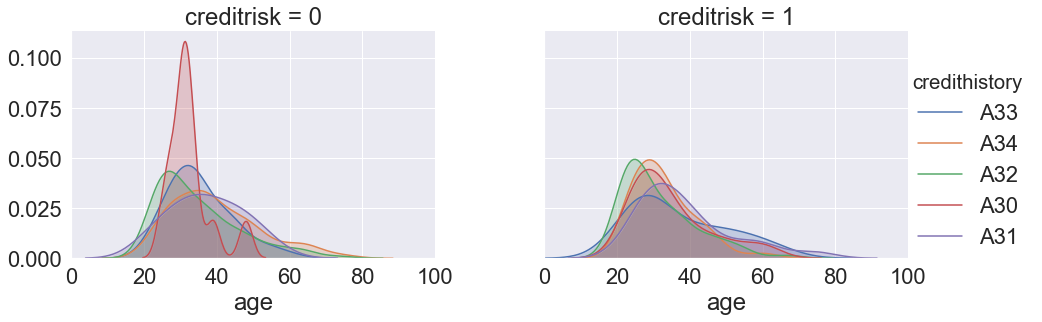

In [26]:
k = sns.FacetGrid(train, col="creditrisk", hue='credithistory', height=5, aspect = 1.3)
k.map(sns.kdeplot, "age", shade=True).add_legend().fig.subplots_adjust(wspace=.3)
sns.set(font_scale=2)
plt.xlim(0, 100)

#### How does the purpose of the credit affect the proportion of defaulters by credit amount?

For purpose of the credit, the category "Others" is the most risky and obscure purpose.

Text(0.5, 1.0, 'Credit Amount distribuition by Purposes')

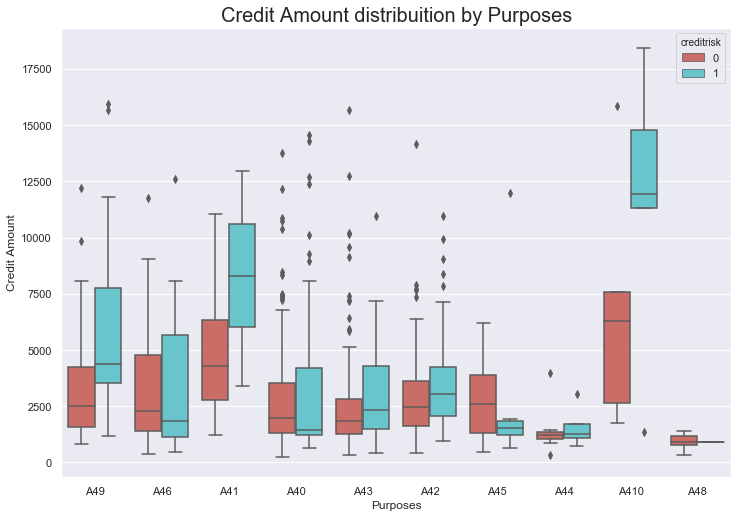

In [27]:
sns.set(rc={'figure.figsize':(12,8.27)})
k = sns.boxplot(x="purpose", y="creditamount", data=train, palette="hls", hue = "creditrisk")
k.set_xlabel("Purposes", fontsize=12)
k.set_ylabel("Credit Amount", fontsize=12)
k.set_title("Credit Amount distribuition by Purposes", fontsize=20)

In [28]:
pd.set_option('display.max_columns', 100)
pd.crosstab(train['creditrisk'],train['job']).apply(lambda r: r/r.sum(), axis=1)

job,A171,A172,A173,A174
creditrisk,,,,
0,0.021467,0.200358,0.629696,0.148479
1,0.020747,0.157676,0.634855,0.186722


**How does the type of job affect the proportion of defaulters by credit amount?**

People in management positions and ranked as highly qualified employees tend to be more riskier!

Text(0.5, 1.0, 'Credit Amount distribuition by type of job')

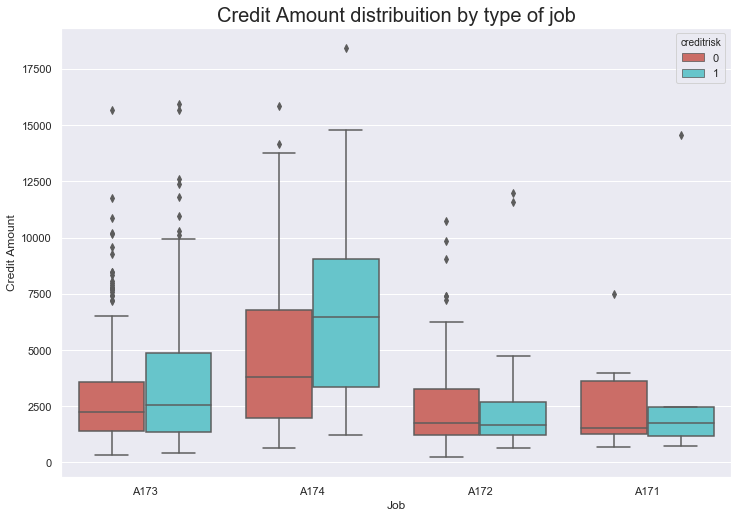

In [29]:
sns.set(rc={'figure.figsize':(12,8.27)})
g2 = sns.boxplot(x="job", y="creditamount", data=train, palette="hls", hue = "creditrisk")
g2.set_xlabel("Job", fontsize=12)
g2.set_ylabel("Credit Amount", fontsize=12)
g2.set_title("Credit Amount distribuition by type of job", fontsize=20)

## 4. Preparing the data

### Feature selection

Feature selection is motivated by the intuitive concept that not all features are equally important. I tried 4 different methods to select the most influential features:

- **Baseline model**: includes all the features except the variables "Present residence since", "Number of existing credits" and "Number of people being liable to provide maintenance for the loan". I deleted manually these features based on their poor ability to explain any difference in the target variable.
- **Standard deviation** groups features by credit risk in order to compute the standard deviation of the difference between good and bad credit risk. The categorical variables are treated as continuous and the numerical variables are binned into 8 equal parts. The idea is to try to capture the variance of the target variable through features' variance. **Criteria to select variables: standard deviation higher than 0.10.**
- **Spearman's rank-order correlation (absolute value)** includes features based on a correlation above 0.05 with the target variable.  
- **Random forest classifier** returns importance scores for each variable, all the importance scores add up to 100%. **Criteria to select variables**: importance score above 0.005. 

The problem with all these methods is to find when ‘‘enough is enough’’ to select an appropriate threshold. 

**Standard Deviation:** 

In [30]:
def std_calc(df,var): 
    if  df[var].dtypes == "object": 
        data = df.groupby([var])['creditrisk'].agg(['count','sum']) 
        data.columns = ["Total","bad"]     
        data["good"] = data["Total"] - data["bad"] 
        data["%bad"] = data["bad"]/data["Total"] 
        data["%good"] = data["good"]/data["Total"]
        data["std"] = (data["%good"] - data["%bad"])
        return data["std"].std()
    else: 
        df['bin_var'] = pd.qcut(df[var].rank(method='first'),8) 
        data = df.groupby(['bin_var'])['creditrisk'].agg(['count','sum']) 
        data.columns = ["Total","bad"]     
        data["good"] = data["Total"] - data["bad"] 
        data["%bad"] = data["bad"]/data["Total"] 
        data["%good"] = data["good"]/data["Total"]
        data["std"] = (data["%good"] - data["%bad"])
        return data["std"].std()

In [31]:
train_copy = train.copy()

std_list = []
for col in Total_Cols:
    val = std_calc(train_copy,var = col)
    dt_type = train_copy[col].dtypes
    std_list.append((val,col,dt_type))

std_list = sorted(std_list,reverse = True)

for i in range(len(std_list)):
    print (std_list[i][0],",",std_list[i][1],",type =",std_list[i][2])

0.4103167221236258 , credithistory ,type = object
0.32873891820912027 , existingchecking ,type = object
0.28446523728711226 , foreignworker ,type = object
0.23907900724253978 , purpose ,type = object
0.20563782280926202 , savings ,type = object
0.20041029343395939 , duration ,type = int64
0.1958492094221671 , property ,type = object
0.19528538877352059 , housing ,type = object
0.19403607911932255 , creditamount ,type = int64
0.15836215276565116 , age ,type = int64
0.14673454831766866 , otherinstallment ,type = object
0.1448143163310932 , employmentsince ,type = object
0.13731395691304432 , otherdebtors ,type = object
0.11450062470919109 , statussex ,type = object
0.0993910027546328 , existingcredits ,type = int64
0.08379396500601083 , peopleliable ,type = int64
0.08065490339615347 , job ,type = object
0.07126409634992523 , residencesince ,type = int64
0.05897941529526575 , installmentrate ,type = int64
0.037880720420707926 , telephone ,type = object


In [32]:
# List of variables to be used later                  
Num_SD=[]
for i in range(len(std_list)):
    if std_list[i][0]>0.1 and std_list[i][2]=='int64': 
        Num_SD.append(std_list[i][1])

Cat_SD=[]
for i in range(len(std_list)):
    if std_list[i][0]>0.1 and std_list[i][2]=='object': 
        Cat_SD.append(std_list[i][1])

In [33]:
Num_SD

['duration', 'creditamount', 'age']

In [34]:
Cat_SD

['credithistory',
 'existingchecking',
 'foreignworker',
 'purpose',
 'savings',
 'property',
 'housing',
 'otherinstallment',
 'employmentsince',
 'otherdebtors',
 'statussex']

**Spearman correlation**

Preprocessing data

In [35]:
X_train_SP=X_train.copy()
X_train_SP = pd.get_dummies(X_train_SP, columns=catvars)
X_test_SP=X_test.copy()
X_test_SP = pd.get_dummies(X_test_SP, columns=catvars)
X_train_SP.shape, X_test_SP.shape

((800, 61), (200, 61))

In [36]:
cols_names=X_train_SP.columns.values.tolist()
X_train_SP_arr =X_train_SP.values
cols_names

['duration',
 'creditamount',
 'installmentrate',
 'residencesince',
 'age',
 'existingcredits',
 'peopleliable',
 'existingchecking_A11',
 'existingchecking_A12',
 'existingchecking_A13',
 'existingchecking_A14',
 'credithistory_A30',
 'credithistory_A31',
 'credithistory_A32',
 'credithistory_A33',
 'credithistory_A34',
 'purpose_A40',
 'purpose_A41',
 'purpose_A410',
 'purpose_A42',
 'purpose_A43',
 'purpose_A44',
 'purpose_A45',
 'purpose_A46',
 'purpose_A48',
 'purpose_A49',
 'savings_A61',
 'savings_A62',
 'savings_A63',
 'savings_A64',
 'savings_A65',
 'employmentsince_A71',
 'employmentsince_A72',
 'employmentsince_A73',
 'employmentsince_A74',
 'employmentsince_A75',
 'statussex_A91',
 'statussex_A92',
 'statussex_A93',
 'statussex_A94',
 'otherdebtors_A101',
 'otherdebtors_A102',
 'otherdebtors_A103',
 'property_A121',
 'property_A122',
 'property_A123',
 'property_A124',
 'otherinstallment_A141',
 'otherinstallment_A142',
 'otherinstallment_A143',
 'housing_A151',
 'housing_

In [37]:
sp_corr=[]
for i in range(len(X_train_SP_arr.transpose())):
    coef, p = spearmanr(y_train,X_train_SP_arr[:,i])
    sp_corr.append(np.absolute(coef))

sp_df=pd.DataFrame(sp_corr,index=cols_names, columns=['sp_corr'])

Text(0.5, 1.0, 'Spearman correlation')

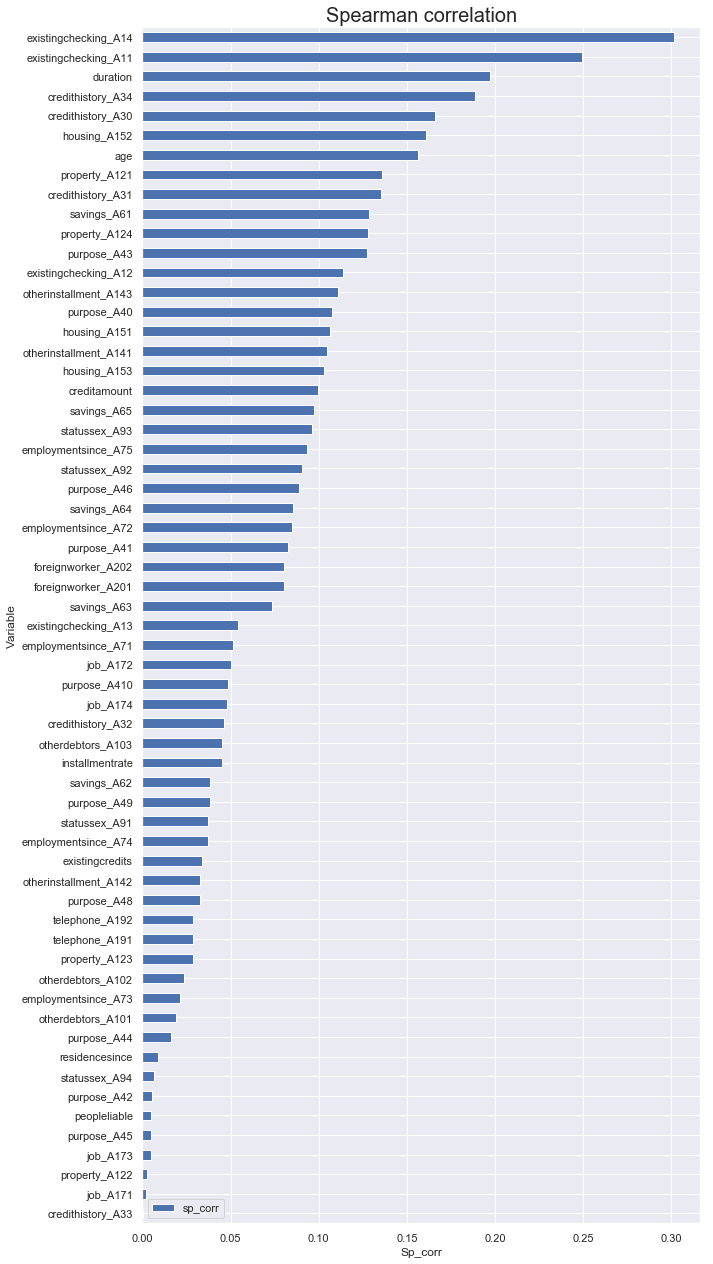

In [38]:
sp_sorted=sp_df.sort_values("sp_corr").plot.barh(figsize=(10,22))
sp_sorted.set_xlabel("Sp_corr", fontsize=12)
sp_sorted.set_ylabel("Variable", fontsize=12)
sp_sorted.set_title("Spearman correlation", fontsize=20)

Selecting features with a correlation higher than 0.05. 

In [39]:
sp_df=sp_df.loc[sp_df['sp_corr'] > 0.05]
sp_variables=list(sp_df.index)
X_train_SP=X_train_SP[sp_variables]
X_test_SP=X_test_SP[sp_variables]
X_train_SP.shape, X_test_SP.shape

((800, 33), (200, 33))

**Random Forest Classifier**

Preprocessing data

In [40]:
X_train_RF=X_train.copy()
X_test_RF=X_test.copy()
X_train_RF = pd.get_dummies(X_train_RF, columns=catvars)
X_test_RF = pd.get_dummies(X_test_RF, columns=catvars)
X_train_RF.shape, X_test_RF.shape

((800, 61), (200, 61))

In [41]:
cols_names=X_train_RF.columns.values.tolist()
X_train_RF_arr =X_train_RF.values
cols_names;

In [42]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_RF_arr,y_train)

#print(model.feature_importances_) 

featimp=[]
for i in range(len(X_train_RF_arr.transpose())):
    featimp.append(model.feature_importances_[i])

np.sum(featimp)

1.0

Text(0.5, 1.0, 'Random Forest Classifier')

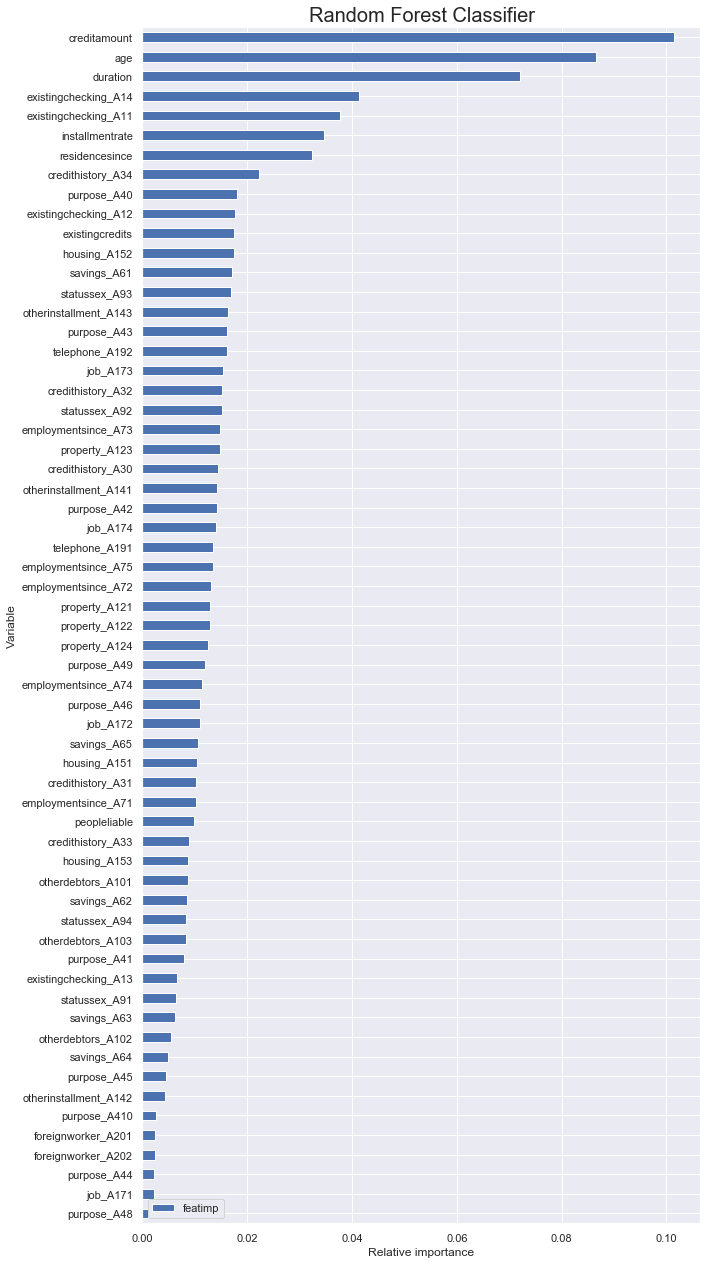

In [43]:
rf_sorted=pd.DataFrame(featimp,index=cols_names, columns=['featimp']).sort_values("featimp").plot.barh(figsize=(10,22))
rf_sorted.set_xlabel("Relative importance", fontsize=12)
rf_sorted.set_ylabel("Variable", fontsize=12)
rf_sorted.set_title("Random Forest Classifier", fontsize=20)

Selecting features with a importance higher than 0.005. 

In [44]:
sfm = SelectFromModel(model, threshold=0.005) 

### Feature engineering

I encoded all categorical variables and standardized the variables credit amount and duration. Besides I bucket the variable age. 

Furthermore, I deleted the variables "Present residence since", "Number of existing credits", and "Number of people being liable" in the Baseline Model because of their reduced ability to explain any difference in the target variable.

In [45]:
for df in [X_train, X_test, X_train_SP, X_test_SP, X_train_RF, X_test_RF]:
    df['age'] = df["age"] // 25 * 25
    df[['creditamount', 'duration']] = StandardScaler().fit_transform(df[['creditamount', 'duration']].astype(np.float64))

### Pipelines

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
    
from sklearn.pipeline import Pipeline


#Basline
num_features_BL = ['creditamount', 'duration', 'installmentrate', 'age']

num_pipeline_BL = Pipeline([("select_numeric", DataFrameSelector( num_features_BL))])

#Educated guess
num_features_SD = Num_SD

num_pipeline_SD = Pipeline([("select_numeric", DataFrameSelector(num_features_SD ))])

In [47]:
from sklearn.preprocessing import OneHotEncoder 

#Baseline
cat_features_BL = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallment', 'housing', 'job', 
           'telephone', 'foreignworker']
cat_pipeline_BL= Pipeline([("select_cat", DataFrameSelector( cat_features_BL )),("cat_encoder", OneHotEncoder(sparse=False))])

#Educated guess
cat_features_SD = Cat_SD
cat_pipeline_SD = Pipeline([("select_cat", DataFrameSelector( cat_features_SD )),("cat_encoder", OneHotEncoder(sparse=False))])

In [48]:
from sklearn.pipeline import FeatureUnion
#Baseline
preprocess_pipeline_BL = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline_BL),("cat_pipeline", cat_pipeline_BL)])

#Educated guess
preprocess_pipeline_SD = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline_SD),("cat_pipeline", cat_pipeline_SD)])

**Baseline model**

In [49]:
X_train_BL = preprocess_pipeline_BL.fit_transform(X_train)
X_test_BL = preprocess_pipeline_BL.fit_transform(X_test)

print(X_train_BL.shape, X_test_BL.shape)

(800, 58) (200, 58)


In [50]:
all_features = num_features_BL.copy()
all_features.extend(cat_features_BL)
X_train.loc[:, all_features ].head()

,creditamount,duration,installmentrate,age,existingchecking,credithistory,purpose,savings,employmentsince,statussex,otherdebtors,property,otherinstallment,housing,job,telephone,foreignworker
29,1.199912,3.297082,3,50,A11,A33,A49,A61,A75,A93,A101,A124,A143,A152,A173,A192,A201
535,-0.359630,-0.008051,2,25,A13,A34,A46,A61,A72,A91,A101,A123,A143,A151,A173,A191,A201
695,-0.733547,-1.279256,2,50,A14,A32,A41,A63,A73,A93,A101,A122,A143,A151,A173,A191,A201
557,0.567050,-0.008051,1,25,A14,A30,A40,A65,A73,A92,A101,A122,A141,A152,A173,A192,A201
836,-0.854388,-0.770774,4,0,A14,A32,A43,A65,A73,A92,A101,A123,A143,A152,A173,A191,A201


**Standard Deviation**

In [51]:
X_train_SD = preprocess_pipeline_SD.fit_transform(X_train)
X_test_SD = preprocess_pipeline_SD.fit_transform(X_test)

print(X_train_SD.shape, X_test_SD.shape)

(800, 51) (200, 51)


In [52]:
all_features = num_features_SD.copy()
all_features.extend(cat_features_SD)
X_train.loc[:, all_features ].head()

,duration,creditamount,age,credithistory,existingchecking,foreignworker,purpose,savings,property,housing,otherinstallment,employmentsince,otherdebtors,statussex
29,3.297082,1.199912,50,A33,A11,A201,A49,A61,A124,A152,A143,A75,A101,A93
535,-0.008051,-0.359630,25,A34,A13,A201,A46,A61,A123,A151,A143,A72,A101,A91
695,-1.279256,-0.733547,50,A32,A14,A201,A41,A63,A122,A151,A143,A73,A101,A93
557,-0.008051,0.567050,25,A30,A14,A201,A40,A65,A122,A152,A141,A73,A101,A92
836,-0.770774,-0.854388,0,A32,A14,A201,A43,A65,A123,A152,A143,A73,A101,A92


**Spearman Correlation**

In [53]:
X_train_SP.loc[:, sp_variables].head()

,duration,creditamount,age,existingchecking_A11,existingchecking_A12,existingchecking_A13,existingchecking_A14,credithistory_A30,credithistory_A31,credithistory_A34,purpose_A40,purpose_A41,purpose_A43,purpose_A46,savings_A61,savings_A63,savings_A64,savings_A65,employmentsince_A71,employmentsince_A72,employmentsince_A75,statussex_A92,statussex_A93,property_A121,property_A124,otherinstallment_A141,otherinstallment_A143,housing_A151,housing_A152,housing_A153,job_A172,foreignworker_A201,foreignworker_A202
29,3.297082,1.199912,50,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0
535,-0.008051,-0.359630,25,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0
695,-1.279256,-0.733547,50,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0
557,-0.008051,0.567050,25,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
836,-0.770774,-0.854388,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0


In [54]:
X_train_SP=X_train_SP.values
X_test_SP=X_test_SP.values

In [55]:
X_train_SP.shape

(800, 33)

**Random Forest Classifier**

In [56]:
X_train_RF.loc[:, sp_variables].head()

,duration,creditamount,age,existingchecking_A11,existingchecking_A12,existingchecking_A13,existingchecking_A14,credithistory_A30,credithistory_A31,credithistory_A34,purpose_A40,purpose_A41,purpose_A43,purpose_A46,savings_A61,savings_A63,savings_A64,savings_A65,employmentsince_A71,employmentsince_A72,employmentsince_A75,statussex_A92,statussex_A93,property_A121,property_A124,otherinstallment_A141,otherinstallment_A143,housing_A151,housing_A152,housing_A153,job_A172,foreignworker_A201,foreignworker_A202
29,3.297082,1.199912,50,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0
535,-0.008051,-0.359630,25,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0
695,-1.279256,-0.733547,50,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0
557,-0.008051,0.567050,25,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
836,-0.770774,-0.854388,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0


In [57]:
X_train_RF=X_train_RF.values
X_test_RF=X_test_RF.values

In [58]:
sfm.fit(X_train_RF,y_train)
X_train_RF = sfm.transform(X_train_RF)
X_train_RF.shape

(800, 54)

In [59]:
X_test_RF = sfm.transform(X_test_RF)
X_test_RF.shape

(200, 54)

## 5. Select a model

We will use robust and versatile classifier algorithms:

- Logistic regression
- Random Forest
- Gradient Boosting
- K-Nearest-Neighbors
- Decision Trees
- SVM


In [60]:
knn_clf = KNeighborsClassifier()
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
logistic_clf = linear_model.LogisticRegression(solver='liblinear')
svm_clf = SVC(gamma="auto",probability=True)
dectree_clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=100)
gradboost_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=10, random_state=0)

clfs = {
'Logistic Regression' : logistic_clf,
'Random Forest': forest_clf,
'Gradient Boosting': gradboost_clf, 
'KNN': knn_clf,
'Decision Tree': dectree_clf,   
'SVM': svm_clf,
}

## 6. Presenting your solution

On each model, we implemented a 5-fold cross-validation to evaluate the performance of the training set and avoid overfitting. We selected the best classifier based upon their accuracy and their ability to reduce the false negatives, because of misclassification is costly to the financial institution if the model predicts a low credit risk for someone who is actually a high credit risk.

**Decision rule to accept the best model**: the bank should approve the candidate only if the average profit increases or remains the same.

$$\text{Average profit}=\text{Average Credit Amount}*[(\text{Cost of False Negative)}*(\%FN)+(\text{Average Interest Rate})*(\%TN)]$$

Where the cost of a false negative is equal to 100% (total loss) and we can assume an average geometric retun of 20%. So the decision rule becomes:

$$\text{Average profit}=\text{Average Credit Amount}*[(-1.0)*(\%FN)+(0.20)*(\%TN)]$$


 **The best model to decide if a customer is a source of credit risk is the Logistic Classifier**, not only reduced the number of false negatives but also it has the highest profit among other models. However, it is important to mention that using the using feature selection does not certainly enhance performance, as well as converting numerical features as categorical features.

**Our experimental results show that the Baseline model outperforms other methods to enhance accuracy, recall and average profit.** 

Additionally, from these observations, we should definitely include Logistic and Random Forest as prime models to tackle credit default prediction.

**Top 8 models**:

| Model                              	| False Negatives 	| Average Profit 	| CV(5) 	| Accuracy 	| Number of predictors 	|
|------------------------------------	|-----------------	|----------------	|-------	|----------	|----------------------	|
| Baseline_Logistic                  	| 22              	| 49.1           	| 0.747 	| 0.810    	| 58                   	|
| Standard Deviation_Logistic         	| 23              	| 45.8           	| 0.752 	| 0.825    	| 51                   	|
| RFFI_Logistic                      	| 24              	| 3.3            	| 0.746 	| 0.780    	| 54                   	|
| Spearman correlation_Random Forest 	| 28              	| -29.4          	| 0.744 	| 0.810    	| 33                   	|
| Spearman correlation_Logistic      	| 29              	| -62.2          	| 0.754 	| 0.780    	| 33                   	|
| Standard Deviation_Random Forest    	| 31              	| -91.6          	| 0.749 	| 0.775    	| 51                   	|
| Baseline_Random Forest             	| 32              	| -85.1          	| 0.755 	| 0.805    	| 58                   	|
| RFFI_Random Forest                 	| 34              	| -124.3         	| 0.758 	| 0.785    	| 54                   	|



### Baseline Model

In [61]:
Results_BL = pd.DataFrame(columns = ['Model', 'CV(5)', 'Accuracy', 'Precision_score', 'Recall_score','Average Precision','F1_score'])
average_precision_BL=[]

for credit_model, credit_model_name in zip(clfs.values(), clfs.keys()):
    credit_model.fit(X_train_BL, y_train)
    y_pred_BL = credit_model.predict(X_test_BL)
    y_score_BL = credit_model.predict_proba(X_test_BL)[:,1]
    average_precision_BL.append(average_precision_score(y_test, y_score_BL))
    Score_BL = cross_val_score(credit_model, X_train_BL, y_train, cv=5).mean()

    t = pd.Series({ 
                     'Model': credit_model_name,
                     'CV(5)': Score_BL,
                     'Accuracy': metrics.accuracy_score(y_test, y_pred_BL),
                     'Precision_score': metrics.precision_score(y_test, y_pred_BL),
                     'Recall_score': metrics.recall_score(y_test, y_pred_BL),                    
                     'F1_score': metrics.f1_score(y_test, y_pred_BL)
                 })


    Results_BL = Results_BL.append(t,ignore_index = True)
    Results_BL['Average Precision']=average_precision_BL

print( '\033[1m' 'Baseline Model:{} predictors used'.format(X_train_BL.shape[1]))
Results_BL

Baseline Model:58 predictors used


,Model,CV(5),Accuracy,Precision_score,Recall_score,Average Precision,F1_score
0,Logistic Regression,0.747480,0.810,0.698113,0.627119,0.688625,0.660714
1,Random Forest,0.755035,0.805,0.794118,0.457627,0.669913,0.580645
2,Gradient Boosting,0.726230,0.765,0.650000,0.440678,0.558768,0.525253
3,KNN,0.715042,0.705,0.500000,0.338983,0.451785,0.404040
4,Decision Tree,0.697433,0.720,0.565217,0.220339,0.499689,0.317073
5,SVM,0.694987,0.745,0.833333,0.169492,0.622063,0.281690


In [62]:
Aver_Credit=credit_data['creditamount'].mean()
Aver_IR=0.2

cm_BL_Log = confusion_matrix(y_test,logistic_clf.predict(X_test_BL))
cm_BL_RF = confusion_matrix(y_test,forest_clf.predict(X_test_BL))
print('\033[1m''Confusion Matrix: Logistic Classifier \n {} ,  \n \n Confusion Matrix: Random Forest \n{}'.format(cm_BL_Log,cm_BL_RF))

Confusion Matrix: Logistic Classifier 
 [[125  16]
 [ 22  37]] ,  
 
 Confusion Matrix: Random Forest 
[[134   7]
 [ 32  27]]


**Decision Rule**

In [63]:
DR_1=Aver_Credit*(-1*(cm_BL_Log [1,0]/cm_BL_Log .sum())+Aver_IR*(cm_BL_Log [0,0]/cm_BL_Log .sum()))
DR_2=Aver_Credit*(-1*(cm_BL_RF[1,0]/cm_BL_RF.sum())+Aver_IR*(cm_BL_RF[0,0]/cm_BL_RF.sum()))

print('\033[1m''Average Profit \n  Logistic Classifier: {} \n  Random Forest: {}'.format(DR_1,DR_2))

Average Profit 
  Logistic Classifier: 49.06887 
  Random Forest: -85.05270799999998


### Standard Deviation

In [64]:
Results_SD = pd.DataFrame(columns = ['Model', 'CV(5)', 'Accuracy', 'Precision_score', 'Recall_score','Average Precision','F1_score'])
average_precision_SD=[]

for credit_model, credit_model_name in zip(clfs.values(), clfs.keys()):
    credit_model.fit(X_train_SD, y_train)
    y_pred_SD = credit_model.predict(X_test_SD)
    y_score_SD = credit_model.predict_proba(X_test_SD)[:,1]
    average_precision_SD.append(average_precision_score(y_test, y_score_SD))
    Score_SD = cross_val_score(credit_model, X_train_SD, y_train, cv=5).mean()

    t = pd.Series({ 
                     'Model': credit_model_name,
                     'CV(5)': Score_SD,
                     'Accuracy': metrics.accuracy_score(y_test, y_pred_SD),
                     'Precision_score': metrics.precision_score(y_test, y_pred_SD),
                     'Recall_score': metrics.recall_score(y_test, y_pred_SD),                    
                     'F1_score': metrics.f1_score(y_test, y_pred_SD)
                 })


    Results_SD = Results_SD.append(t,ignore_index = True)
    Results_SD['Average Precision']=average_precision_SD

print( '\033[1m' 'Standard Deviation Method:{} predictors used'.format(X_train_SD.shape[1]))
Results_SD

Standard Deviation Method:51 predictors used


,Model,CV(5),Accuracy,Precision_score,Recall_score,Average Precision,F1_score
0,Logistic Regression,0.752496,0.825,0.750000,0.610169,0.668958,0.672897
1,Random Forest,0.748730,0.775,0.666667,0.474576,0.619825,0.554455
2,Gradient Boosting,0.718621,0.750,0.595745,0.474576,0.565454,0.528302
3,KNN,0.703714,0.715,0.521739,0.406780,0.441709,0.457143
4,Decision Tree,0.697433,0.720,0.565217,0.220339,0.499689,0.317073
5,SVM,0.697503,0.740,0.818182,0.152542,0.633596,0.257143


In [65]:
cm_SD_Log = confusion_matrix(y_test,logistic_clf.predict(X_test_SD))
cm_SD_RF = confusion_matrix(y_test,forest_clf.predict(X_test_SD))
print('\033[1m''Confusion Matrix: Logistic Classifier \n {} ,  \n \n Confusion Matrix: Random Forest \n{}'.format(cm_SD_Log,cm_SD_RF))

Confusion Matrix: Logistic Classifier 
 [[129  12]
 [ 23  36]] ,  
 
 Confusion Matrix: Random Forest 
[[127  14]
 [ 31  28]]


**Decision Rule**

In [66]:
DR_1=Aver_Credit*(-1*(cm_SD_Log [1,0]/cm_SD_Log .sum())+Aver_IR*(cm_SD_Log [0,0]/cm_SD_Log .sum()))
DR_2=Aver_Credit*(-1*(cm_SD_RF[1,0]/cm_SD_RF.sum())+Aver_IR*(cm_SD_RF[0,0]/cm_SD_RF.sum()))

print('\033[1m''Average Profit \n  Logistic Classifier: {} \n  Random Forest: {}'.format(DR_1,DR_2))

Average Profit 
  Logistic Classifier: 45.797611999999994 
  Random Forest: -91.59522399999999


### Spearman Correlation

In [67]:
Results_SP = pd.DataFrame(columns = ['Model', 'CV(5)', 'Accuracy', 'Precision_score', 'Recall_score','Average Precision','F1_score'])
average_precision_SP=[]

for credit_model, credit_model_name in zip(clfs.values(), clfs.keys()):
    credit_model.fit(X_train_SP, y_train)
    y_pred_SP = credit_model.predict(X_test_SP)
    y_score_SP = credit_model.predict_proba(X_test_SP)[:,1]
    average_precision_SP.append(average_precision_score(y_test, y_score_SP))
    Score_SP = cross_val_score(credit_model, X_train_SP, y_train, cv=5).mean()

    t = pd.Series({ 
                     'Model': credit_model_name,
                     'CV(5)': Score_SP,
                     'Accuracy': metrics.accuracy_score(y_test, y_pred_SP),
                     'Precision_score': metrics.precision_score(y_test, y_pred_SP),
                     'Recall_score': metrics.recall_score(y_test, y_pred_SP),                    
                     'F1_score': metrics.f1_score(y_test, y_pred_SP)
                 })


    Results_SP = Results_SP.append(t,ignore_index = True)
    Results_SP['Average Precision']=average_precision_SP

print( '\033[1m' 'Spearman Correlations Method:{} predictors used'.format(X_train_SP.shape[1]))
Results_SP

Spearman Correlations Method:33 predictors used


,Model,CV(5),Accuracy,Precision_score,Recall_score,Average Precision,F1_score
0,Logistic Regression,0.753746,0.780,0.666667,0.508475,0.652986,0.576923
1,Random Forest,0.743746,0.810,0.756098,0.525424,0.659455,0.620000
2,Gradient Boosting,0.716246,0.750,0.615385,0.406780,0.560897,0.489796
3,KNN,0.698698,0.700,0.488372,0.355932,0.441071,0.411765
4,Decision Tree,0.697433,0.720,0.565217,0.220339,0.499689,0.317073
5,SVM,0.707496,0.725,0.625000,0.169492,0.625191,0.266667


In [68]:
cm_SP_Log = confusion_matrix(y_test,logistic_clf.predict(X_test_SP))
cm_SP_RF = confusion_matrix(y_test,forest_clf.predict(X_test_SP))
print('\033[1m''Confusion Matrix: Logistic Classifier \n {} ,  \n \n Confusion Matrix: Random Forest \n{}'.format(cm_SP_Log,cm_SP_RF))

Confusion Matrix: Logistic Classifier 
 [[126  15]
 [ 29  30]] ,  
 
 Confusion Matrix: Random Forest 
[[131  10]
 [ 28  31]]


**Decision Rule**

In [69]:
DR_1=Aver_Credit*(-1*(cm_SP_Log [1,0]/cm_SP_Log .sum())+Aver_IR*(cm_SP_Log [0,0]/cm_SP_Log .sum()))
DR_2=Aver_Credit*(-1*(cm_SP_RF[1,0]/cm_SP_RF.sum())+Aver_IR*(cm_SP_RF[0,0]/cm_SP_RF.sum()))

print('\033[1m''Average Profit \n  Logistic Classifier: {} \n  Random Forest: {}'.format(DR_1,DR_2))

Average Profit 
  Logistic Classifier: -62.15390199999996 
  Random Forest: -29.441322000000024


#### Random Forest Feature Importance

In [70]:
Results_RF = pd.DataFrame(columns = ['Model', 'CV(5)', 'Accuracy', 'Precision_score', 'Recall_score','Average Precision','F1_score'])
average_precision_RF=[]

for credit_model, credit_model_name in zip(clfs.values(), clfs.keys()):
    credit_model.fit(X_train_RF, y_train)
    y_pred_RF = credit_model.predict(X_test_RF)
    y_score_RF = credit_model.predict_proba(X_test_RF)[:,1]
    average_precision_RF.append(average_precision_score(y_test, y_score_RF))
    Score_RF = cross_val_score(credit_model, X_train_RF, y_train, cv=5).mean()

    t = pd.Series({ 
                     'Model': credit_model_name,
                     'CV(5)': Score_RF,
                     'Accuracy': metrics.accuracy_score(y_test, y_pred_RF),
                     'Precision_score': metrics.precision_score(y_test, y_pred_RF),
                     'Recall_score': metrics.recall_score(y_test, y_pred_RF),                    
                     'F1_score': metrics.f1_score(y_test, y_pred_RF)
                 })


    Results_RF = Results_RF.append(t,ignore_index = True)
    Results_RF['Average Precision']=average_precision_RF

print( '\033[1m' 'Random Forest Classifier Method:{} predictors used'.format(X_train_RF.shape[1]))
Results_RF


Random Forest Classifier Method:54 predictors used


,Model,CV(5),Accuracy,Precision_score,Recall_score,Average Precision,F1_score
0,Logistic Regression,0.746191,0.780,0.636364,0.593220,0.669568,0.614035
1,Random Forest,0.757520,0.785,0.735294,0.423729,0.685395,0.537634
2,Gradient Boosting,0.721191,0.760,0.657143,0.389831,0.600609,0.489362
3,KNN,0.726214,0.710,0.513514,0.322034,0.424938,0.395833
4,Decision Tree,0.697433,0.720,0.565217,0.220339,0.499689,0.317073
5,SVM,0.705011,0.740,0.769231,0.169492,0.609796,0.277778


In [71]:
cm_RF_Log = confusion_matrix(y_test,logistic_clf.predict(X_test_RF))
cm_RF_RF = confusion_matrix(y_test,forest_clf.predict(X_test_RF))
print('\033[1m''Confusion Matrix: Logistic Classifier \n {} ,  \n \n Confusion Matrix: Random Forest \n{}'.format(cm_RF_Log,cm_RF_RF))

Confusion Matrix: Logistic Classifier 
 [[121  20]
 [ 24  35]] ,  
 
 Confusion Matrix: Random Forest 
[[132   9]
 [ 34  25]]


**Decision Rule**

In [72]:
DR_1=Aver_Credit*(-1*(cm_RF_Log [1,0]/cm_RF_Log .sum())+Aver_IR*(cm_RF_Log [0,0]/cm_RF_Log .sum()))
DR_2=Aver_Credit*(-1*(cm_RF_RF[1,0]/cm_RF_RF.sum())+Aver_IR*(cm_RF_RF[0,0]/cm_RF_RF.sum()))

print('\033[1m''Average Profit \n  Logistic Classifier: {} \n  Random Forest: {}'.format(DR_1,DR_2))


Average Profit 
  Logistic Classifier: 3.2712580000000027 
  Random Forest: -124.30780400000002


### Mis-classified as Good Clients (False negative) in the best model: Baseline Model

In [73]:
ms=np.where(y_test==1)
ms=[item.tolist() for item in ms][0]
len(ms)

59

In [74]:
logistic_clf.fit(X_train_BL, y_train)
y_pred_BL = logistic_clf.predict(X_test_BL)
BM_FN=np.where(y_pred_BL==0)
BM_FN=[item.tolist() for item in BM_FN][0]

In [75]:
Misclassified_GoodClients=set(ms).intersection(BM_FN)

L=len(Misclassified_GoodClients)
print("Customers misclassified as good customers: {}".format(L))
Misclassified_GoodClients

Customers misclassified as good customers: 22


{0,
 15,
 32,
 47,
 48,
 62,
 69,
 78,
 79,
 101,
 102,
 116,
 117,
 125,
 131,
 132,
 136,
 153,
 159,
 185,
 190,
 194}